# 1. Введение

В предыдущем модуле мы рассмотрели базовые принципы работы с моделями на этапе продакшена.

**Мы научились:**

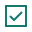 сохранять обученные модели в виде бинарных файлов, а также файлов других форматов, которые поддерживаются языками программирования, отличными от Python;

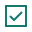 локально разворачивать собственный веб-сервис с помощью фреймворка Flask, встраивая в его работу свою модель машинного обучения;

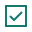 оптимизировать работу этого веб-сервиса, увеличивая его пропускную способность с помощью таких инструментов, как uWSGI и NGINX.

Однако, как мы уже упомянули в конце прошлого модуля, осталась одна проблема: наш сервис (да и сама модель) работает только на нашем компьютере. Когда мы зальём исходный код на GitHub, а наш коллега Василий склонирует себе репозиторий и попробует запустить сервис на своём «боевом» сервере, нет гарантии, что приложение запустится.

Что, если на сервере Василия нет необходимых зависимостей, таких как Scikit Learn, Flask и так далее? Установить библиотеки несложно, но какие именно их версии нужны Василию? А что, если у него уже стоят некоторые библиотеки, которые вы использовали, но в совершенно другой версии, которая не совместима с вашим приложением?

Кроме того, для обеспечения работы сервиса в связке uWSGI + NGINX Василию придётся проделывать все те манипуляции, которые мы производили в прошлом модуле. Вы уже должны были убедиться, что процесс настройки взаимодействия uWSGI + NGINX + Flask не из лёгких, пусть его и можно обернуть в некоторую инструкцию.

А что, если, ко всему прочему, на сервере Василия стоит другая операционная система, например Windows, которая не поддерживает работу с uWSGI?

Так много вопросов… И у нас есть на них ответы. Проблема, к которой мы подошли, называется **проблемой воспроизводимости**. О ней, как правило, не задумываются новички, однако она часто проявляется на этапе продакшена. Например, мы хотим перенести проект с локальной машины, где вели разработку, на реальный сервер, но из-за разницы в настройках и конфигурациях этот процесс становится болезненным и требует затрат времени, которого всегда остаётся очень мало на этапе продакшена.

В этом модуле мы разберём, как сделать свой код воспроизводимым и как изолировать свой сервис так, чтобы его можно было запустить на любой машине, а самое главное — как сделать это быстро и просто.

**Цели модуля:**

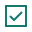 Узнать, что такое воспроизводимость и какими инструментами её можно обеспечить.

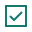 Познакомиться с терминами «виртуализация» и «контейнеризация».

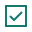 Научиться создавать виртуальные окружения, изолировать среду разработки, устанавливать и фиксировать зависимости в виртуальных окружениях.

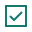 Познакомиться с инструментом контейнеризации Docker.

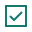 Научиться писать Dockerfile, создавать образы контейнеров, запускать их, а также делиться ими с помощью хостинга docker-образов Docker Hub.

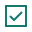 Создать docker-образ для нашего веб-сервиса и запустить его в контейнере.

### С КАКИМ ПРОЕКТОМ БУДЕМ РАБОТАТЬ?

В предыдущем модуле мы написали маленький веб-сервис. В нём функционирует модель машинного обучения, которая выполняет предсказания для данных, поступающих через POST-запросы по эндпоинту `'/predict'`.

Перед прохождением модуля давайте зафиксируем, как должна выглядеть директория нашего проекта:

```
├─web
   ├─models
        └─model.pkl
   └─client.py
   └─server.py
```

Проект будет располагаться в директории web, в которой находятся файлы:

* server.py — содержит интерфейс сервера, реализованный на Flask. В интерфейсе предусмотрено два эндпоинта:
    * `'/'` — корневой, по обращению к которому пользователю возвращается тестовое сообщение;
    * `'/predict'` — предназначенный для обработки POST-запросов. Запросы приходят в виде списка из четырёх чисел в формате `json()`. Результатом выполнения запроса является JSON-словарь с ключом `'prediction'` и значением-предсказанием модели.
    Вы писали функцию для обработки этого запроса в [прошлом модуле](https://lms.skillfactory.ru/courses/course-v1:SkillFactory+DST-3.0+28FEB2021/jump_to_id/4be04c897b3c439c932297a7fa603ce1#codeblock).
* client.py — скрипт для тестирования POST-запросов на сервер.
* models — папка с моделями, в которой находится файл model.pkl с моделью.

**Файл server.py**

```
from flask import Flask, request, jsonify
import pickle
import numpy as np

# загружаем модель из файла
with open('models/model.pkl', 'rb') as pkl_file:
    model = pickle.load(pkl_file)

# создаём приложение
app = Flask(__name__)

@app.route('/')
def index():
    msg = "Тестовое сообщение. Сервер запущен!"
    return msg

@app.route('/predict', methods=['POST'])
def predict():
    #ваш код здесь
    pass

if __name__ == '__main__':
    app.run('localhost', 5000)
```

**Файл client.py**

```
import requests

if __name__ == '__main__':
    # выполняем POST-запрос на сервер по эндпоинту add с параметром json
    r = requests.post('http://localhost:5000/predict', json=[1, 0, 1, 24])
    # выводим статус запроса
    print('Status code: {}'.format(r.status_code))
    # реализуем обработку результата
    if r.status_code == 200:
        # если запрос выполнен успешно (код обработки=200),
        # выводим результат на экран
        print('Prediction: {}'.format(r.json()['prediction']))
    else:
        # если запрос завершён с кодом, отличным от 200,
        # выводим содержимое ответа
        print(r.text)
```

В этом модуле мы сделаем наш сервис изолированным и поместим его в контейнер.

# 2. Воспроизводимость

Код, разрабатываемый дата-сайентистом, должен быть воспроизводимым в постоянно меняющихся в условиях:

* меняются данные, поступающие на вход;
* трансформируются пайплайны предобработки данных;
* постоянно изменяются гиперпараметры алгоритмов;
* иногда модифицируются или вовсе удаляются алгоритмы популярных библиотек.

В идеале ожидается, что выполнение кода должно приводить к одинаковым результатам в различных условиях. Именно с этой целью в некоторых заданиях вы встречали требование зафиксировать параметр `random seed` — таким образом, вы уже неоднократно сталкивались с проблемой воспроизводимости на практике.

Воспроизводимость результатов является одним из главных показателей качества модели. Именно поэтому обеспечение воспроизводимости — одна из важнейших проблем в современном ML-инжиниринге.

Мы можем доверять результату, полученному с помощью модели, только когда доподлинно известно, на какой выборке и с каким пайплайном предобработки она была построена. Кроме того, ожидается, что результаты будут консистентными (согласованными с исходными данными), так как необходимо однозначно понимать, какое изменение привело к улучшению или ухудшению результатов.

Наиболее остро вопрос воспроизводимости стоит в случае, когда над одной моделью работает большая DS-команда. Каждый участник команды должен воспроизвести весь пайплайн и получить тот же самый результат. При этом возможные изменения должны доставляться в общий код так же быстро, сохраняя все требования к воспроизводимости.

На схеме приведён классический пайплайн работы над моделью:

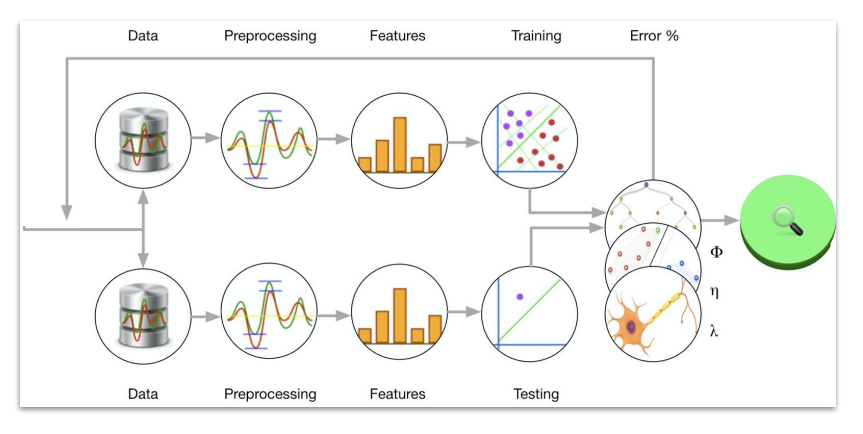

## **Инструменты обеспечения воспроизводимости:**

* **Версионирование кода.**
Обычно весь пайплайн представлен в виде частей кода, для работы с которым используется знакомая нам распределённая система управления версиями Git в совокупности с хостингом GitHub.

* **Версионирование артефактов.**
В процессе работы над проектом появляются различные артефакты: датасеты, модели, файлы конфигурации и прочее. Для их версионирования обычно используются такие инструменты, как [DVC](https://dvc.org/) и [Sonatype Nexus](https://www.sonatype.com/product-nexus-repository).

* **Виртуализация и контейнеризация.**
Одним из важнейших аспектов воспроизводимости является настройка окружения.

**Виртуализация** — это технология изоляции, сохранения состояния и воспроизведения окружения. Благодаря ей вы можете воссоздать на другом компьютере точную копию вашего окружения и тем самым обеспечить воспроизводимость.

Однако иногда воссоздания окружения недостаточно и необходимо обеспечить не только воспроизводимость версий библиотек, но и воспроизводимость среды выполнения программы — операционной системы, на которой реализован проект. Для этого прибегают к инструментам **контейнеризации**, таким как Docker.

Все перечисленные выше инструменты мы подробно обсудим далее.

* **Управление экспериментами.**
Для каждого запуска обучения необходимо фиксировать настройки гиперпараметров и сохранять их. В этом помогают системы управления экспериментами, например [MLflow](https://mlflow.org/).

Над созданием универсального стандарта воспроизводимости работают многие крупные компании. Это означает, что у каждой компании пока что существуют собственные требования к обеспечению воспроизводимости. Когда вы начнёте работать в DS-команде, ваши коллеги будут требовать от вас их соблюдения. Обычно чем крупнее компания, тем более серьёзные требования к воспроизводимости необходимо соблюдать. Поскольку единого стандарта пока не существует, пути и используемые в разных компаниях инструменты могут кардинально отличаться.

Рекомендуем вам всегда помнить о задаче воспроизводимости результатов модели. Это позволит вам постепенно привить себе тот уровень культуры кода, который будет удовлетворять самые требовательные компании.

Задание 2.1

Изменение каких факторов может негативно повлиять на воспроизводимость результатов?
Отметьте все подходящие варианты ответов.

- [X] A Данные, поступающие на вход модели во время её обучения
- [X] B Гиперпараметры алгоритмов
- [X] C Новые версии библиотек
- [X] D Пайплайн предобработки (препроцессинга) данных

Верно:
* A Верно.
* B Верно.
* C Верно.
* D Верно.

Задание 2.2

Выберите примеры плохой воспроизводимости:
- [X] A При перезапуске инференса модели на одинаковых датасетах получаем разные предикты (ответы модели).
- [ ] B При перезапуске инференса модели на разных датасетах получаем одинаковые предикты (ответы модели).
- [ ] C Данные для обучения обновляются один раз в день, модель переобучается один раз в день, инференс модели в разные дни даёт разные предикты (ответы модели).
- [X] D Ваш коллега обучил модель, получил результат precision=0.73 на тестовом датасете и передал вам код. Вы делаете инференс на том же тестовом датасете и получаете результат precision=0.77.
- [ ] E Вы обучили модель и получили результат инференса на тестовом датасете precision=0.73. Затем вы решили добавить нормализацию одного из признаков перед обучением модели и получили результат precision=0.77.

Верно:

* A Верно.
* D Верно.

Задание 2.3

Для чего необходимы инструменты виртуализации и контейнеризации?
- [ ] Чтобы изменение в настройках программ сразу применялось на всех устройствах.
- [ ] Чтобы датасеты, файлы конфигураций и прочие артефакты хранились в одном месте.
- [ ] Чтобы загрузить модель в облако.
- [X] Чтобы обеспечить единые версии библиотек и ОС.

верно


# 3. Виртуализация и изолированность. Virtualenv

При обсуждении воспроизводимости мы упоминали, что одним из важнейших её требований является настройка окружения. Разные версии библиотек в разных проектах могут конфликтовать друг с другом, и становится сложно поддерживать работоспособность всех сервисов. Поэтому необходимо обеспечить не только одинаковые операционные системы, но и установку всех нужных библиотек и их версий.


Почти в 100 % случаев при работе над реальным проектом вам потребуется воссоздать точное окружение на сервере, чтобы обеспечить единообразие среды выполнения. Это включает в себя не только стандартные установленные зависимости и интерпретатор Python, но и специфические зависимости, которые могут работать по-разному на разных операционных системах или на разных их версиях.

Несколько лет назад для этих задач использовали программные решения для удалённого управления конфигурациями. Они создавали **большой конфигурационный файл**, в котором описывались все настройки, зависимости и библиотеки, и на его основе настраивались все удалённые машины. Одним из таких инструментов является [Ansible](https://www.ansible.com/overview/how-ansible-works). Он позволяет через SSH-соединение [SSH-соединение](https://ru.hostings.info/termins/ssh.html) «проталкивать» файлы конфигурации на множество машин и таким образом обеспечивать единообразие.

Другие системы, например [Chef](https://www.chef.io/home/), обычно поступают наоборот: узлы «тянут» (pull) конфигурацию с главной машины. Chef используется и сейчас, когда необходимо привести парк машин к одинаковой конфигурации.

**ПРОБЛЕМЫ**

* Когда в системе много сервисов и при этом каждый сервис запускается на разных машинах, становится тяжело следить за полнотой и правильностью конфигурационных файлов.
* На локальном компьютере разработчика может быть не установлено (или наоборот установлено) ПО, напрямую влияющее на стабильность работы приложения.
  
Намного проще создать для каждого проекта виртуальную среду, изолированную от основной системы. Тогда каждый из проектов будет иметь свои **независимые настройки**, в том числе разные библиотеки и их версии.

Когда мы говорим про **изолированность**, мы имеем в виду, что приложение будет запускаться в своей отдельной среде и таким образом не зависеть от ОС и настроек системы, на которой мы его разворачиваем.

Задание 3.1

Для чего предназначен инструмент Ansible?
- [ ] Создаёт контейнеры и управляет ими.
- [ ] Создаёт виртуальные машины и управляет ими.
- [ ] Управляет виртуальными средами.
- [X] Помогает управлять конфигурациями удалённых серверов.

верно

### VIRTUALENV

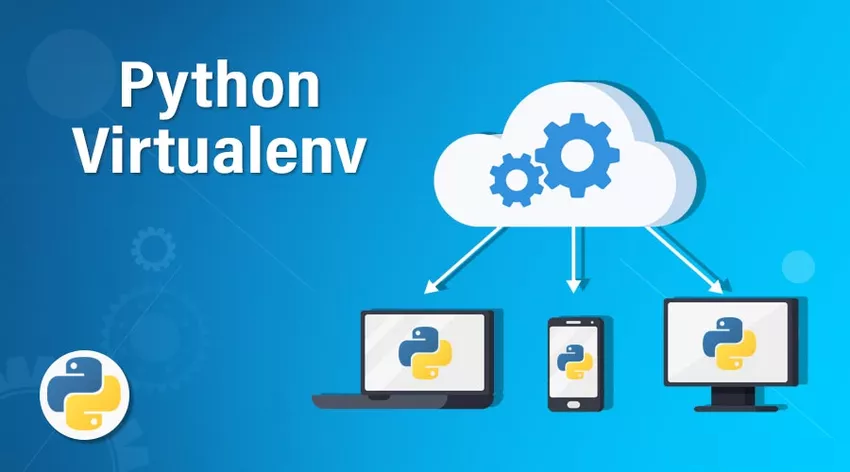

Одним из наиболее популярных инструментов для создания изолированных сред в Python является virtualenv. Он обеспечивает работоспособность сервисов вне зависимости от того, какие они имеют зависимости.

**Примечание.** Сначала мы будем изучать основы работы с виртуальными окружениями на «игрушечных» примерах, а затем рассмотрим, как настроить виртуальное окружение для нашего веб-сервиса.

Предварительно создайте в своей операционной системе папку с именем project_a. Эта папка будет имитировать папку проекта, и на её основе мы продемонстрируем работу виртуальных окружений. Перейдите в созданную папку в терминале (команда `cd /путь/до/папки`) или откройте её в вашей IDE.

Чтобы установить virtualenv, необходимо воспользоваться стандартной командой:

`$ pip install virtualenv`

**Примечание.** Здесь и далее символ $ будет означать, что команды выполняются в терминале (для Windows — в командной строке). **Вводить его не нужно** — вводите только текст команды!

Напомним, что в VS Code терминал (в Windows — командную строку) можно открыть с помощью кнопки в верхнем меню IDE:

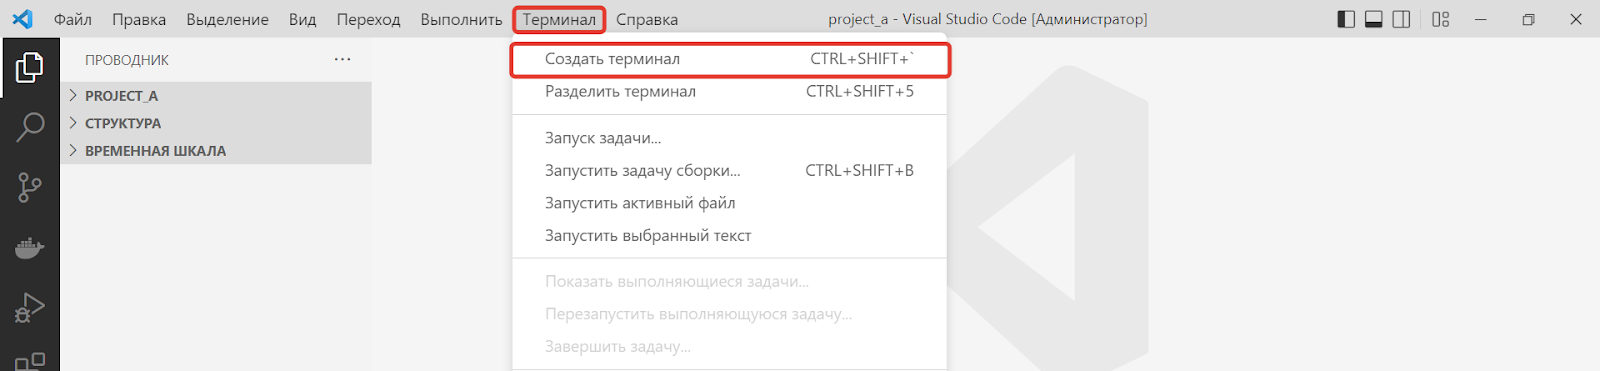

Так как принципы работы с инструментом незначительно, но отличаются для различных UNIX-систем (Linux и MacOS) и Windows, мы приведём инструкции по работе для каждой из ОС.

**Примечание.** Чтобы показать, что команды в терминале выполняются в виртуальном окружении, мы будем перед символом $ писать в скобках имя виртуального окружения, в котором происходит работа. Например:

`(project_a_venv) $ pip install pandas`

**Windows**

Чтобы создать новую среду, необходимо набрать в терминале команду:

`$ python -m venv <название сервиса>`

Например, следующая команда создаёт виртуальное окружение с именем project_a_venv:

`$ python -m venv project_a_venv`

После этого в вашей текущей директории появится папка проекта с именем, которое вы указали в команде `venv`.

В UNIX-системах эта директория будет выглядеть примерно следующим образом (имена файлов могут незначительно отличаться в зависимости от версии Python, которую вы используете):

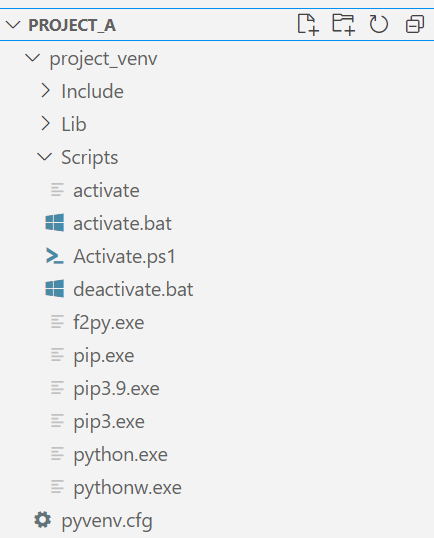

Директория Scripts — это аналог директории bin в UNIX-системах: в ней лежат файлы, которые взаимодействуют со средой, например файлы для активации и деактивации среды.

В папке Lib содержится копия python и все зависимости (библиотеки и их версии).

Чтобы активировать виртуальное окружение в Windows, необходимо в командной строке запустить файл Activate.ps1:

`$ project_a_venv/Scripts/Activate.ps1`

**Если не получается активировать среду в Windows**

У вас могут возникнуть трудности с активацией среды в VS Code, в частности это может быть связано с тем, что для успешного запуска несистемных скриптов в Windows необходимо активировать политику выполнения для пользователя. Для этого в меню «Пуск» найдите приложение PowerShell и запустите его от имени администратора:

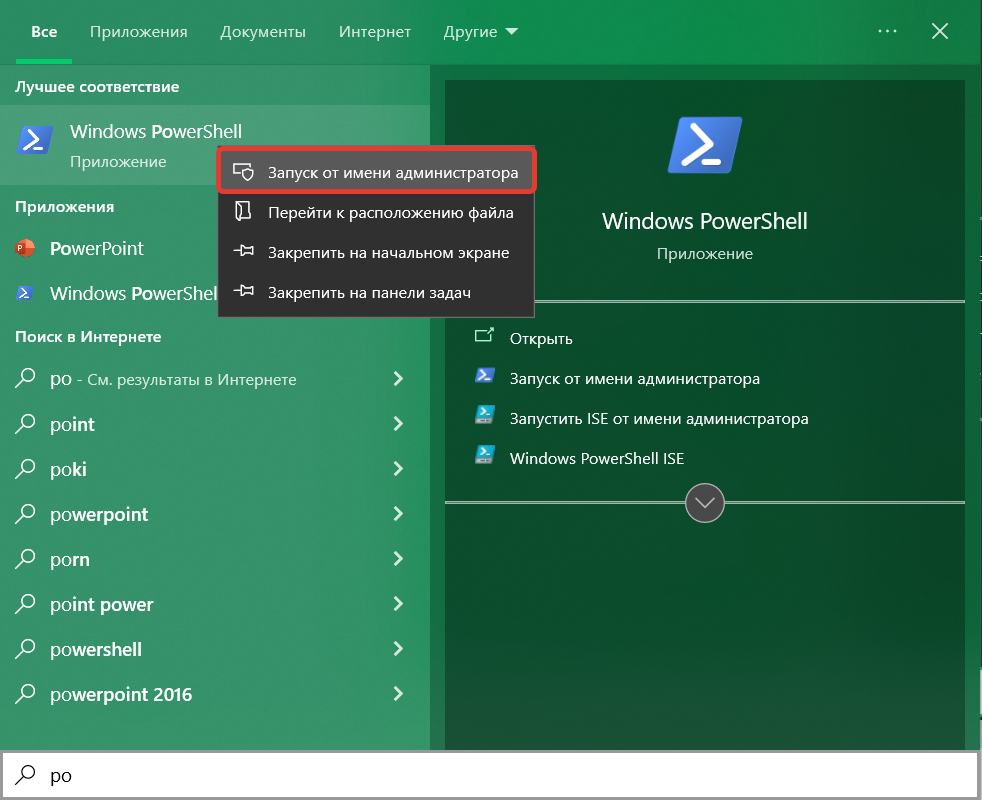

В открывшемся терминале введите следующую команду:

`$ Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process`

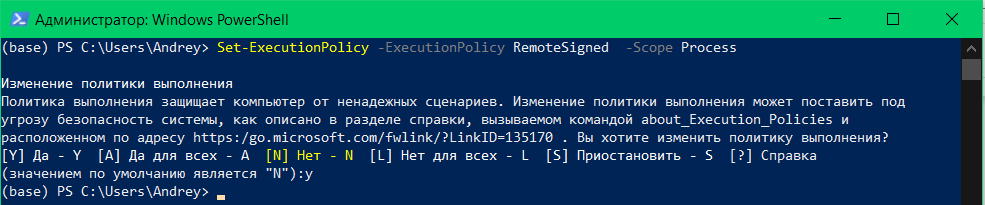

Если после выполнения описанных выше действий активация среды продолжает вызывать ошибку, вам могут помочь следующие ссылки: [один](https://www.youtube.com/watch?v=mHV1Yh7McWA), [два](https://www.youtube.com/watch?v=g9AeWgZJTZA).

Если команда выполнилась успешно, вы увидите, что перед приглашением в командной строке появилась дополнительная надпись, совпадающая с именем виртуального окружения. В результате выполнения команды мы увидим следующее:

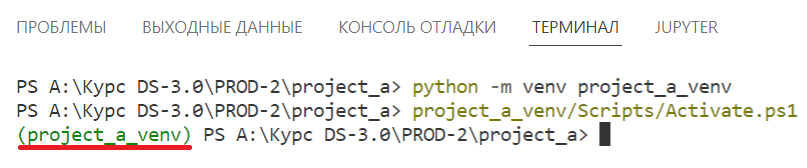

Выделенная красным строка говорит нам, что мы находимся в изолированном окружении project_a_venv.

Таким образом вы полностью изолируете окружение своего проекта и можете установить все необходимые для работы проекта версии пакетов — эти версии не будут отражены в глобальном окружении Python и будут зафиксированы только в активированном виртуальном окружении.

Например, выполним команду для установки библиотеки scikit-learn:

`(project_a_venv) $ pip install scikit-learn`

После установки библиотеки вы увидите, что в папке Lib/site-packages появится scikit-learn, а также зависимости, необходимые для работы этой библиотеки (например, numpy, scipy и joblib) — они устанавливаются вместе с ней автоматически.

Чтобы выйти из виртуального окружения в область глобального окружения, необходимо ввести в терминале следующую команду:

`$ deactivate`

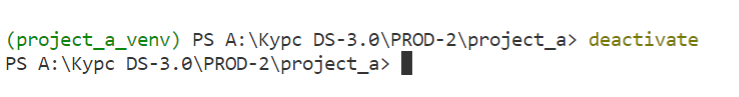

Задание 3.2

Какой командой можно активировать виртуальное окружение virtualenv?
- [ ] pip install virtualenv
- [X] source <название_окружения>/bin/activate — для UNIX или <название_окружения>/- [ ] Scripts/Activate.ps1 — для Windows
- [ ] python3 -m venv <название окружения> — для UNIX или python -m venv <название окружения> — для Windows
- [ ] virtualenv -p
- [ ] deactivate

верно

Задание 3.3

Какой командой можно деактивировать виртуальное окружение virtualenv?
- [ ] pip install virtualenv
- [ ] source <название_окружения>/bin/activate — для UNIX или <название_окружения>/Scripts/Activate.ps1 — для Windows
- [ ] python3 -m venv <название_окружения> — для UNIX или python -m venv <название_окружения> — для Windows
- [ ] virtualenv -p
- [X] deactivate

верно

## VIRTUALENV И VS CODE

Если вы разрабатываете свои программы в IDE, например в VS Code, то перемещаться между виртуальными окружениями становится совсем просто.

Давайте предварительно создадим в папке нашего проекта пустой py-файл, чтобы VS Code понял, что мы работаем с языком Python. Назовём этот файл app.py.

Чтобы переключиться между окружениями в VS Code, необходимо перейти в раздел выбора интерпретатора Python (правый нижний угол):

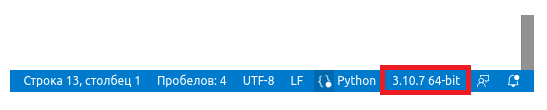

По умолчанию используется глобальное окружение. Нам нужно переключиться на только что созданное виртуальное окружение:

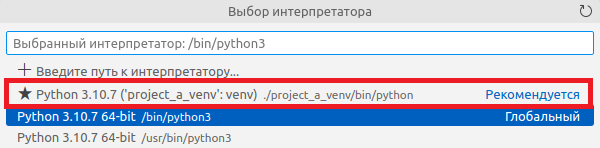

После этого необходимо перезапустить терминал (если он был открыт).

Результат будет тем же, что и после активации виртуального окружения через командную строку:

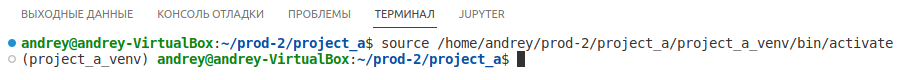

**Примечание.** Если вы устанавливали среду Anaconda, то вашим окружением по умолчанию будет среда base. В пакет Anaconda входит инструмент conda, который одновременно является и менеджером пакетов (как pip), и менеджером среды (как venv). С его помощью также можно создавать виртуальные окружения и управлять ими. Подробнее о conda и её различиях с pip и venv вы можете узнать здесь.

## ИЗОЛЯЦИЯ ЗАВИСИМОСТЕЙ

Теперь давайте на примере рассмотрим, как работать с виртуальными окружениями.

Рядом с папкой project_a создайте ещё одну папку проекта и назовите её project_b. В этой папке также создайте пустой файл app.py.

Откройте два терминала: в первом перейдите в папку project_a, а во втором — в project_b. Также можно открыть эти папки в двух окнах VS Code.

В папке с проектом А создадим виртуальное окружение с именем project_a_venv, активируем его и установим scikit-learn (если вы не делали этого ранее):

Windows
```
$ python -m venv project_a_venv
$ project_a_venv/Scripts/Activate.ps1
(project_a_venv)$ pip install -q scikit-learn
```
Примечание. Ключ -q предназначен для установки без вывода справочной информации — «тихая» установка (от англ. quiet — тихий).

Затем создадим виртуальное окружение в папке project_b с именем project_b_venv, активируем его и установим пакет pandas.

Windows
```
$ python -m venv project_b_venv
$ project_b_venv/Scripts/Activate.ps1
(project_b_venv)$ pip install -q pandas
```
Давайте посмотрим, какие библиотеки доступны внутри каждого из окружений. Для этого воспользуемся командой pip freeze, которая выводит список установленных пакетов с указанием номера их версии. Выполните в каждом из окружений команду:

`(project_{}_venv)$ pip freeze`

Для проекта А мы увидим примерно следующую картину:

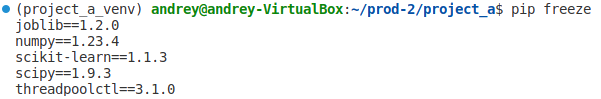

Для проекта B список будет выглядеть так:

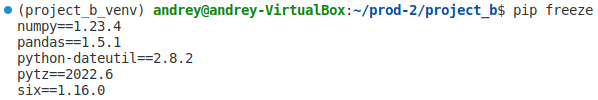

Примечание. На скриншотах приведены результаты работы команд только в UNIX-системах, так как они совпадают с результатами в Windows.

Что мы видим? Списки установленных пакетов отличаются: например, библиотеки scikit-learn нет в виртуальном окружении проекта B, а библиотеки pandas нет в виртуальном окружении проекта A. Списки пакетов для проектов А и B пересекаются только в одном — библиотеке numpy. Так происходит потому, что и scikit-learn, и pandas требуют для своей стандартной работы пакет numpy.

Теперь давайте взглянём на список глобально установленных пакетов. Для этого откроем ещё один терминал и, не активируя никаких окружений, напишем в нём команду для вывода списка установленных пакетов:

`$ pip freeze`

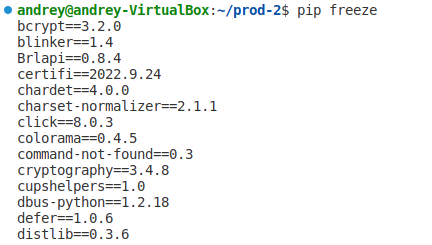

В глобальном окружении находится совершенно другой список зависимостей.

**Примечание.** Пакеты в глобальном окружении на вашем компьютере могут отличаться от приведённых на скриншоте.

Только что мы посмотрели на пример **изоляции**: мы создали отдельные виртуальные окружения для каждого из проектов, зависимости которых изолированы друг от друга. Из приведённого примера становится интуитивно понятно, что виртуальные окружения существуют независимо от глобального и установка пакета в одно из них не означает, что пакет будет установлен в какое-то другое окружение, и наоборот.

Например, если мы установим в глобальное окружение библиотеку numpy версии 1.19.2,

`$ pip install numpy==1.19.2`

то для виртуальных окружений проектов А и B версия numpy не изменится. Это утверждение справедливо и в обратную сторону. Такой механизм позволяет нам работать с проектами А и B независимо друг от друга и даже независимо от глобального окружения, тем самым гибко управляя проектами.

**Примечание.** Очевидно, что попытка запустить в окружении код, использующий библиотеку, которая в нём не установлена, приведёт к ошибке. Например, если попробовать импортировать библиотеку pandas в файле app.py проекта A,

**Файл project_a/app.py**
```
import pandas as pd

df = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})
print(df)
```
а после запустить этот файл из-под соответствующего виртуального окружения, мы получим ошибку импорта:
```
(project_a_venv) $ python3 app.py

Traceback (most recent call last):
  File "/home/andrey/prod-2/project_a/app.py", line 1, in <module>
    import pandas as pd
ModuleNotFoundError: No module named 'pandas'
```
Поэтому стоит иметь в виду, что для каждого создаваемого виртуального окружения необходимо отдельно установить все зависимости, которые не входят в [стандартную библиотеку](https://docs.python.org/3/library/index.html) Python.

Однако это ещё не всё. Когда разработка проекта завершена и мы готовы загрузить его на свой GitHub и поделиться им с коллегами, мы можем сохранить все те версии библиотек, которые использовали при разработке, в файл. Для этого применяется всё та же команда `pip freeze`, только с указанием имени файла, в который необходимо произвести запись. Традиционно такой файл называют requirements.txt и располагают в корневой директории проекта. Для указания файла используется ключ -r или оператор `>`:

`(project_a_venv) $ pip freeze -r requirements.txt`

или

`(project_a_venv) $ pip freeze > requirements.txt`

В результате создаётся текстовый файл requirements.txt, который вы можете поместить в свой репозиторий на GitHub.

Когда коллеги будут клонировать ваш проект, им не нужно будет разбираться, какие библиотеки вы использовали в проекте, а тем более — каких версий. Они смогут создать на своём компьютере собственное виртуальное окружение и установить в него все необходимые зависимости, используя лишь одну команду:

`(имя_виртуального_окружения) $ pip install requirements.txt`

Удобно, не правда ли?

Теперь давайте заглянем «под капот» и поймём, как именно работает изоляция.

## КАК РАБОТАЕТ ИЗОЛЯЦИЯ

Чтобы понять, как работает изоляция, давайте проверим, где располагаются исполняемые файлы Python в случае глобального и виртуального окружений.

Для начала посмотрим на глобальное окружение. С деактивированной средой запускаем команду:

Windows

`$ Get-Command python | Format-Table Source`

Данная команда выводит расположение скрипта, который выполняется при вызове команды python.

Теперь попробуйте запустить ту же самую команду, но уже находясь в одном из виртуальных окружений, например в виртуальном окружении проекта А:

Windows
```
(project_a_venv) $ Get-Command python | Format-Table Source
…\project_a\project_a_venv\Scripts\python.exe
```
Видно, что, активировав среду, мы получаем другой путь к интерпретатору Python. Но как подключение библиотек зависит от расположения интерпретатора? Напрямую.

Мы не будем подробно останавливаться на том, как происходит внутреннее управление путями в операционных системах, так как это довольно обширная тема и её изложение будет уникально для каждого типа операционных систем. Если говорить вкратце, при активации виртуального окружения вы меняете специальные переменные среды ОС, в результате чего при запуске команды вызова интерпретатора используете не глобальную версию интерпретатора Python, который имеет доступ ко всем установленным пакетам, а его копию, которая лежит в папке с виртуальным окружением. Этот интерпретатор не имеет доступа к папке, где хранятся библиотеки, установленные в глобальное или любое другое виртуальное окружение — у него она своя. Это же правило работает и в обратную сторону.

**Примечание.** Подробнее о том, как меняются переменные среды, можно узнать в [этой статье](https://habr.com/ru/post/418579/).

## ПРИЧИНЫ ИСПОЛЬЗОВАНИЯ ВИРТУАЛЬНЫХ ОКРУЖЕНИЙ

У вас мог возникнуть вопрос: зачем это нужно? Зачем так сложно? Раньше мы спокойно работали в глобальном окружении и даже не знали, что оно глобальное, а сейчас для каждого проекта придётся создавать отдельное виртуальное окружение?

Если вы хотите стать профессиональными разработчиками, работать в команде и обеспечивать воспроизводимость библиотек с минимальной затратой времени, то да — создавать виртуальные окружения вам придётся чуть ли не в каждом проекте.

Представим следующую ситуацию: у вас есть два проекта — проект A и проект B. Они оба имеют зависимость от одной и той же библиотеки. Проблема становится явной, когда мы начинаем запрашивать разные версии этой библиотеки. Например, может случиться так, что проект A запрашивает версию 1.0.0, а проект B — версию 2.0.0, причём версия 2.0.0 настолько сильно отличается от 1.0.0, что для адаптации проекта А под новую версию придётся его полностью переписывать. Это большая проблема для Python, ведь работая только в глобальном окружении, мы не можем использовать обе версии библиотеки. Так или иначе, возникнет конфликт, который могут решить виртуальные окружения.

Вторая причина использования виртуальных окружений — удобная коммуникация внутри команды. Разрабатывая проект в виртуальном окружении, мы можем сохранить **только те зависимости и их версии**, которые использовали в проекте, например в файл requirements.txt.

Затем мы можем передать разработку своим коллегами (например, через GitHub), и они смогут установить только те зависимости, которые необходимы для работы нашего кода.

**Примечание.** Важно отметить, что папку самого виртуального окружения в GitHub помещать не нужно. Всегда добавляйте эту папку в файл .gitignore.

Например, мы можем прописать в файле .gitignore строку `*venv/`, которая будет означать, что всё содержимое папок, названия которых оканчиваются на `venv`, будет игнорироваться при коммитах:

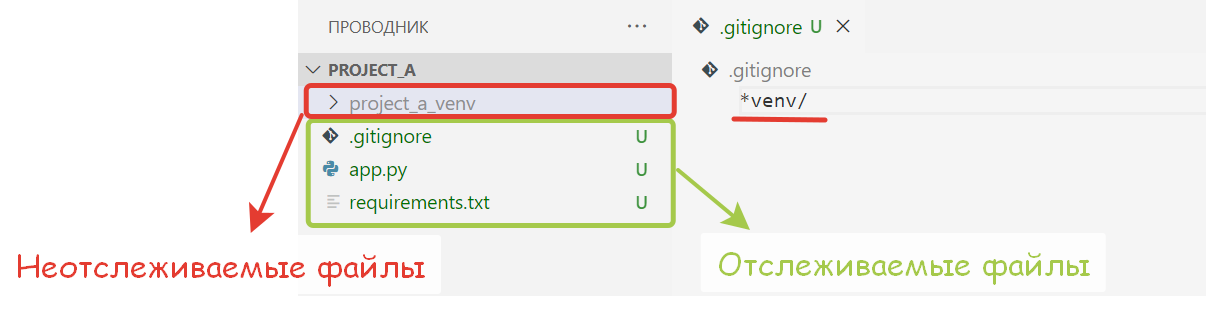

Подробнее о том, как сочетать использование виртуальных окружений с .gitignore, вы можете почитать здесь.

**ВИРТУАЛЬНОЕ ОКРУЖЕНИЕ ДЛЯ FLASK-ПРИЛОЖЕНИЯ**

Пришло время создать виртуальное окружения для нашего веб-сервиса.

Предварительно перейдите в каталог, где расположен код вашего проекта из предыдущего модуля.

В корневой директории проекта (у нас она называется web) создадим виртуальное окружение с именем project_venv.

Windows

`$ python -m venv project_venv`

Локальные копии Python и pip будут установлены в каталог project_venv в каталоге вашего проекта.

Активируем виртуальное окружение:

Windows

`$ project_venv/Scripts/Activate.ps1`

Теперь мы можем переходить к установке пакетов в наше окружение. Сначала установим wheel с локальным экземпляром pip, чтобы убедиться, что наши пакеты будут устанавливаться даже при отсутствии архивов wheel:

`(project_venv) $ pip install wheel`

Затем установим Flask, requests и scikit-learn. Чтобы установить несколько пакетов сразу, можно просто перечислить их через пробел после команды `install`.

`(project_venv) $ pip install flask requests scikit-learn`

Затем запустим наш сервер:

Windows

`(project_venv) $ python ./server.py`

Давайте проверим, что мы установили все необходимые для работы веб-сервиса и его тестирования зависимости. Через браузерную строку зайдите по адресу http://localhost:5000 или http://127.0.0.1:5000. Там должно быть выведено сообщение, что ваш сервер запущен.

Также попробуйте отправить POST-запрос на ваш сервер, выполнив клиентский скрипт в соседнем терминале.

Windows

`(project_venv) $ python ./client.py`

В результате работы скрипта должно быть выведено сообщение о статусе обработки запроса (он должен быть равен 200) и предсказание модели для отправленных данных.

Если всё работает корректно, GET- и POST-запросы отработали без ошибок, то мы можем зафиксировать версии наших зависимостей и поместить их в файл requirements.txt в корневой директории проекта:

`(project_venv) $ pip freeze > requirements.txt`

В нашей директории появится файл requirements.txt — он ещё пригодится в следующих юнитах.

Теперь, если мы загрузим наш код на GitHub (предварительно добавив папку project_venv в файл .gitignore), нашему коллеге Василию необходимо будет склонировать себе репозиторий, а после этого создать виртуальное окружение и активировать его. Чтобы в точности воссоздать все версии зависимостей, которые мы использовали, Василию будет достаточно набрать в терминале следующую команду:

`$ pip install requirements.txt`

После этого зависимости внутри виртуального окружения, созданного Василием, будут совпадать с нашими.

Virtualenv — полезный инструмент. Однако не всё так гладко, ведь он работает только с Python и не обеспечивает полную изоляцию. Также он не позволяет ограничивать ресурсы для каждого сервиса: например, иногда бывает необходимо разрешить одному сервису использование всех ядер процессора и ограничить — другому. Если мы также хотим автоматически балансировать нагрузку между сервисами, то и тут virtualenv нам не помощник.

На эту тему есть [прекрасная статья](https://habr.com/en/post/206024/) на Хабре.

Ещё один недостаток технологии виртуальных окружений состоит в том, что они не помогут, если разработка проекта ведётся на одной операционной системе, а эксплуатация — на другой. В частности, вы могли заметить, что при создании виртуального окружения для нашего веб-сервиса мы ничего не сказали о связке Flask, uWSGI и NGINX — как мы помним по прошлому модулю, эта связка поддерживается только для UNIX-систем. Поэтому нам необходимо создать не просто виртуальное окружение, где мы будет хранить необходимые для работы приложения библиотеки, а что-то вроде карманной операционной системы, внутри которой уже настроено взаимодействие всех необходимых инструментов для работы сервиса, включая установленные внутри версии библиотек. Причём хотелось бы, чтобы эту карманную ОС можно было запускать на любом устройстве, то есть чтобы наш сервис можно было переносить между платформами. Тут к нам на помощь приходят **системы контейнеризации**, в частности **Docker**.